
# A demonstration of a machine learning pipeline

This tutorial will use the titanic dataset where we will try to learn to predict passenger survival based on features such as sex, age and ticket class.

The materials is largely based on the following resources:

- Sickit-learn tutorial: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
- Kaggle notebook: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
- Kaggle notebook: https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [60]:
# Author of Scikit-learn tutorial: Pedro Morales <part.morales@gmail.com>
#
# License: BSD 3 clause
# Modified by Adnane Ez-zizi

In [61]:
%matplotlib inline

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV 

np.random.seed(0)

In [63]:
# To ignore some warning messages
warnings.simplefilter(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter(action='ignore', category=DeprecationWarning) # setting ignore as a parameter and further adding category

We will use the Titanic survival dataset, which contains the following variables:

Variable Name | Description
--------------|-------------
survived      | Survived (1) or died (0)
pclass        | Passenger's class
name          | Passenger's name
sex           | Passenger's sex
age           | Passenger's age
sibsp         | Number of siblings/spouses aboard
parch         | Number of parents/children aboard
ticket        | Ticket number
fare          | Fare
cabin         | Cabin
embarked      | Port of embarkation

## Data preparation

### Loading the data

In [64]:
df = pd.read_csv("iot_intrusion_dataset.csv")
df.head()

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg


In [65]:
# Number of observations
len(df)

625783

In [66]:
# Distribution of the response (or dependent) variable
tab = df['Label'].value_counts()
tab/tab.sum()

Anomaly    0.935963
Normal     0.064037
Name: Label, dtype: float64

### Data splitting 

Here we will divide the dataset into training (70%) and test set (30%). We will use what we call stratified sampling based on the dependent variable to ensure that the frequency distribution of the response variable is approximately equal within the training and test sets. We accomplish this by selecting samples at random within each of the two classes ('0' or '1').

In [67]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 99)
sss.get_n_splits(df.drop(columns = 'Label'), df['Label'])
for (itrain, itest) in sss.split(df.drop(columns = 'Label'), df['Label']):
    train_indexes = itrain
    test_indexes = itest
titanic_train, titanic_test = df.iloc[train_indexes], df.iloc[test_indexes]

In [68]:
# Double check that the distibution of the response variable in the same in the training and test sets
tab_train = titanic_train['Label'].value_counts()
tab_test = titanic_test['Label'].value_counts()
print('-'*30)
print('In the training set:')
print(tab_train/tab_train.sum())
print('-'*30)
print('In the test set:')
print(tab_test/tab_test.sum())

------------------------------
In the training set:
Anomaly    0.935964
Normal     0.064036
Name: Label, dtype: float64
------------------------------
In the test set:
Anomaly    0.935963
Normal     0.064037
Name: Label, dtype: float64


## Data exploration

It is important to note that we are using the training set for all the exploration and modelling steps. The test set is kept to assess the performance of the models at the end and shouldn't be used before to not bias the process

In [69]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438048 entries, 456307 to 17044
Data columns (total 86 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow_ID            438048 non-null  object 
 1   Src_IP             438048 non-null  object 
 2   Src_Port           438048 non-null  int64  
 3   Dst_IP             438048 non-null  object 
 4   Dst_Port           438048 non-null  int64  
 5   Protocol           438048 non-null  int64  
 6   Timestamp          438048 non-null  object 
 7   Flow_Duration      438048 non-null  int64  
 8   Tot_Fwd_Pkts       438048 non-null  int64  
 9   Tot_Bwd_Pkts       438048 non-null  int64  
 10  TotLen_Fwd_Pkts    438048 non-null  float64
 11  TotLen_Bwd_Pkts    438048 non-null  float64
 12  Fwd_Pkt_Len_Max    438048 non-null  float64
 13  Fwd_Pkt_Len_Min    438048 non-null  float64
 14  Fwd_Pkt_Len_Mean   438048 non-null  float64
 15  Fwd_Pkt_Len_Std    438048 non-null  float64
 16

In [70]:
# Convert name, sex, embarked and survived to strings
# And convert pclass, sibsp and parch to integers
titanic_train = titanic_train.astype({"sex":"category", "embarked":"category", "pclass":"Int64", "sibsp":"Int64", "parch":"int64"})
titanic_test = titanic_test.astype({"sex":"category", "embarked":"category", "pclass":"Int64", "sibsp":"Int64", "parch":"int64"})
#titanic_train['boat'] = titanic_train['boat'].astype('Int64')
print(titanic_train.dtypes)

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [71]:
# Check the distribution of missing values
print('Columns with null values:\n\n', titanic_train.isnull().sum())

Columns with null values:

 Flow_ID     0
Src_IP      0
Src_Port    0
Dst_IP      0
Dst_Port    0
           ..
Idle_Max    0
Idle_Min    0
Label       0
Cat         0
Sub_Cat     0
Length: 86, dtype: int64


**Which features are categorical?**

Within categorical features, the values could be nominal or ordinal. Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Within numerical features the values could be discrete (integer values), continuous or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

**Which features are mixed data types?**

Numerical, alphanumeric data within the same feature. These might need to be corrected.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- The feature 'name' may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Five features are integer or floats.
- Five features are strings (object).

In [72]:
titanic_train.drop('Fwd_Seg_Size_Min', axis = 1)
titanic_test.drop('Fwd_Seg_Size_Min', axis = 1)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
354400,192.168.0.24-104.74.213.186-51875-443-6,104.74.213.186,443,192.168.0.24,51875,6,20/08/2019 03:03:08 AM,80,1,1,...,0.0,0.0,0.0,80.00,0.00000,80.0,80.0,Anomaly,Mirai,Mirai-Hostbruteforceg
254311,192.168.0.13-210.89.164.90-60138-8899-17,192.168.0.13,60138,210.89.164.90,8899,17,25/07/2019 03:21:15 AM,105,15,1,...,0.0,0.0,0.0,7.00,2.44949,14.0,4.0,Anomaly,Mirai,Mirai-UDP Flooding
392266,192.168.0.24-210.89.164.90-60147-8899-17,192.168.0.24,60147,210.89.164.90,8899,17,25/07/2019 03:20:57 AM,243,2,1,...,0.0,0.0,0.0,121.50,101.11627,193.0,50.0,Anomaly,Mirai,Mirai-UDP Flooding
355871,192.168.0.13-52.219.40.136-60521-443-6,192.168.0.13,60521,52.219.40.136,443,6,25/07/2019 03:23:39 AM,259,1,1,...,0.0,0.0,0.0,259.00,0.00000,259.0,259.0,Anomaly,Mirai,Mirai-HTTP Flooding
90685,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:23:40 AM,293,0,5,...,0.0,0.0,0.0,73.25,2.50000,77.0,72.0,Anomaly,Mirai,Mirai-HTTP Flooding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391864,192.168.0.24-104.118.134.215-43238-443-6,104.118.134.215,443,192.168.0.24,43238,6,25/07/2019 03:25:02 AM,128,1,1,...,0.0,0.0,0.0,128.00,0.00000,128.0,128.0,Anomaly,Mirai,Mirai-HTTP Flooding
361918,192.168.0.24-210.89.164.90-60036-8899-17,192.168.0.24,60036,210.89.164.90,8899,17,25/07/2019 03:20:35 AM,4,1,1,...,0.0,0.0,0.0,4.00,0.00000,4.0,4.0,Anomaly,Mirai,Mirai-UDP Flooding
213306,192.168.0.13-222.97.164.229-554-5713-6,222.97.164.229,5713,192.168.0.13,554,6,26/05/2019 10:06:39 PM,2228,0,2,...,0.0,0.0,0.0,2228.00,0.00000,2228.0,2228.0,Anomaly,DoS,DoS-Synflooding
310003,192.168.0.13-192.168.0.16-9020-56255-6,192.168.0.16,56255,192.168.0.13,9020,6,10/09/2019 01:43:53 AM,84,0,2,...,0.0,0.0,0.0,84.00,0.00000,84.0,84.0,Anomaly,Mirai,Mirai-Hostbruteforceg


In [73]:
# Check the distribution of numerical feature values
titanic_train.describe(include = 'number')

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,...,438048.000000,438048.0,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000,438048.000000
mean,35006.849042,16386.950809,9.968035,633.494813,1.677444,1.468195,571.211639,929.225647,392.723832,348.407307,...,1.511296,0.0,3.691934,0.341399,4.151563,3.401878,503.148796,52.372858,561.435372,468.024561
std,24727.102282,17547.658341,5.380460,3461.008480,4.330943,1.271163,1170.759133,1811.437905,619.600019,588.224571,...,4.353255,0.0,67.284863,21.203551,89.535289,63.160709,2127.418260,1160.622724,2874.847296,1946.792364
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9020.000000,8899.000000,6.000000,76.000000,0.000000,1.000000,0.000000,18.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,73.000000,0.000000,74.000000,71.000000
50%,51991.000000,9020.000000,6.000000,132.000000,1.000000,1.000000,32.000000,104.000000,30.000000,30.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,93.500000,0.000000,114.000000,78.000000
75%,56361.000000,10101.000000,17.000000,221.000000,2.000000,2.000000,1388.000000,1441.000000,1388.000000,394.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,140.666667,1.527525,154.000000,130.000000
max,65500.000000,65371.000000,17.000000,99984.000000,186.000000,560.000000,109846.000000,773284.000000,1464.000000,1464.000000,...,186.000000,0.0,9044.625000,8598.658250,26785.000000,6654.000000,99973.000000,67071.906623,99973.000000,99973.000000


In [74]:
# Distribution of the number of parents/children aboard
tab = titanic_train['Active_Mean'].value_counts().sort_index()
tab/tab.sum()

0.000000       0.963723
1.000000       0.016201
1.032258       0.000002
1.040000       0.000002
1.041667       0.000002
                 ...   
6644.000000    0.000002
6645.000000    0.000002
6648.000000    0.000002
6654.000000    0.000002
9044.625000    0.000002
Name: Active_Mean, Length: 1587, dtype: float64

In [75]:
# Distribution of the number of siblings/spouse aboard
tab = titanic_train['sibsp'].value_counts().sort_index()
tab/tab.sum()

KeyError: 'sibsp'

In [ ]:
# Distribution of fare
sns.histplot(titanic_train['fare'].dropna(), kde=True)

In [76]:
# Number of people who bought a fare at a price >= 512 (max value)
len(titanic_train[titanic_train['fare']>=512])

KeyError: 'fare'

In [77]:
# Distribution of age
sns.histplot(titanic_train['age'].dropna(), kde=True)

KeyError: 'age'

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 916 or 41% of the actual number of passengers on board the Titanic (2,224).
- Survived is the variable we want to learn to predict with 0 or 1 values.
- Around 38% passengers survived.
- Most passengers (> 76%) did not travel with parents or children.
- Nearly 32% of the passengers had siblings and/or spouse aboard.
- Fares varied quite a lot with one passenger paying as high as $512.
- Age also varied with an average of about 29.9 and standard deviation of 14.3.

In [78]:
# Check the distribution of categorical feature values
titanic_train.describe(include=['object', 'category'])

,Flow_ID,Src_IP,Dst_IP,Timestamp,Label,Cat,Sub_Cat
count,438048,438048,438048,438048,438048,438048,438048
unique,45992,40740,451,4197,2,5,9
top,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,192.168.0.13,25/07/2019 03:25:05 AM,Anomaly,Mirai,Mirai-UDP Flooding
freq,36312,155468,115284,2225,409997,290984,128295


In [79]:
# Distribution of sex
tab = titanic_train['sex'].value_counts()
tab/tab.sum()

KeyError: 'sex'

In [80]:
# Distribution of embarked
tab = titanic_train['embarked'].value_counts()
tab/tab.sum()

KeyError: 'embarked'

**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=916)
- 63.6% of the passengers are male (top=male, freq=583/count=916).
- Cabin values have several dupicates across samples because several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S) with a percentage of 70%
- Ticket feature has high ratio (23.6%) of duplicate values (unique=700).

### Contingency tables

In [ ]:
for col in ['sex', 'pclass', 'embarked', 'sibsp', 'parch']:
    print('Contingency table for survival by:', col)
    print(titanic_train[[col, 'survived']].groupby(col, as_index=False).mean().sort_values(by='survived', ascending=False))
    print('-' * 20, '\n')

### Hypothesis testing: Chi-squared

In [81]:
PClass_survd = pd.pivot_table(titanic_train, index=['Protocol'], columns=['Label'], aggfunc='size')
PClass_survd

Label,Anomaly,Normal
Protocol,,
0,4470,23
6,245144,27943
17,160383,85


In [82]:
t_stat, p_val= stats.ttest_ind(titanic_train['Protocol'], titanic_train['Label'])

print("Chi square value is ", t_stat)
print("P value is", p_val)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Feature engineering

We will create age bands and fare bands for making it easier to explore the relationship between age/fare and the survival. We will then check the contingency with the resulting age/fare bands

In [24]:
titanic_train['age_band'] = pd.cut(titanic_train['age'], 5)
titanic_train[["age_band", "survived"]].groupby(['age_band'], as_index=False).mean().sort_values(by='survived', ascending=False)

,age_band,survived
0,"(0.0959, 14.333]",0.608108
3,"(42.667, 56.833]",0.434343
2,"(28.5, 42.667]",0.400943
1,"(14.333, 28.5]",0.370130
4,"(56.833, 71.0]",0.350000


In [25]:
titanic_train['fare_band'] = pd.cut(titanic_train['fare'], 4)
titanic_train[["fare_band", "survived"]].groupby(['fare_band'], as_index=False).mean().sort_values(by='survived', ascending=False)

,fare_band,survived
3,"(384.247, 512.329]",1.000000
2,"(256.165, 384.247]",0.818182
1,"(128.082, 256.165]",0.694444
0,"(-0.512, 128.082]",0.363322


We will create a two new features family_size (size of the family: include children, parents, spouse and siblings aboard) and is_alone (whether the passenger is travelling alone or not) based on the existing features

In [26]:
# Feature Engineering for train and test/validation dataset
for dataset in [titanic_train, titanic_test]:    

    dataset['family_size'] = dataset ['sibsp'] + dataset['parch'] + 1

    dataset['is_alone'] = 1 #initialize to yes/1 is alone
    dataset['is_alone'].loc[dataset['family_size'] > 1] = 0 # now update to no/0 if family size is greater than 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


We will extract the titles of the passengers from their names

In [27]:
titanic_train['title'] = titanic_train['name'].str.extract(' ([A-Za-z]+)\.', expand=False) # For the training set
titanic_test['title'] = titanic_test['name'].str.extract(' ([A-Za-z]+)\.', expand=False) # For the test set
titanic_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived,age_band,fare_band,family_size,is_alone,title
1168,3,"Sadowitz, Mr. Harry",male,NaN,0,0,LP 1588,7.5750,NaN,S,0,NaN,"(-0.512, 128.082]",1,1,Mr
1078,3,"O'Dwyer, Miss. Ellen 'Nellie'",female,NaN,0,0,330959,7.8792,NaN,Q,1,NaN,"(-0.512, 128.082]",1,1,Miss
957,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S,0,NaN,"(-0.512, 128.082]",5,0,Miss
491,2,"Malachard, Mr. Noel",male,NaN,0,0,237735,15.0458,D,C,0,NaN,"(-0.512, 128.082]",1,1,Mr
84,1,"Cumings, Mr. John Bradley",male,39.0,1,0,PC 17599,71.2833,C85,C,0,"(28.5, 42.667]","(-0.512, 128.082]",2,0,Mr


In [28]:
tab = titanic_train['title'].value_counts()
tab/tab.sum()

Mr          0.574236
Miss        0.204148
Mrs         0.152838
Master      0.044760
Rev         0.008734
Dr          0.003275
Col         0.002183
Mlle        0.002183
Major       0.002183
Ms          0.001092
Don         0.001092
Lady        0.001092
Jonkheer    0.001092
Countess    0.001092
Name: title, dtype: float64

We will make the values consistent and replace many rare categories with a new category "other"

In [29]:
for dataset in [titanic_train, titanic_test]:
    
    # Since many titles occur rarly, we will replace them with a new category "other"
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

    # Make the values consistent
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

In [30]:
titanic_train[['title', 'survived']].groupby(['title'], as_index=False).mean().sort_values(by='survived', ascending=False)

,title,survived
3,Mrs,0.785714
1,Miss,0.684211
0,Master,0.487805
4,Other,0.263158
2,Mr,0.161597


### Data visualisations

<AxesSubplot:xlabel='is_alone', ylabel='survived'>

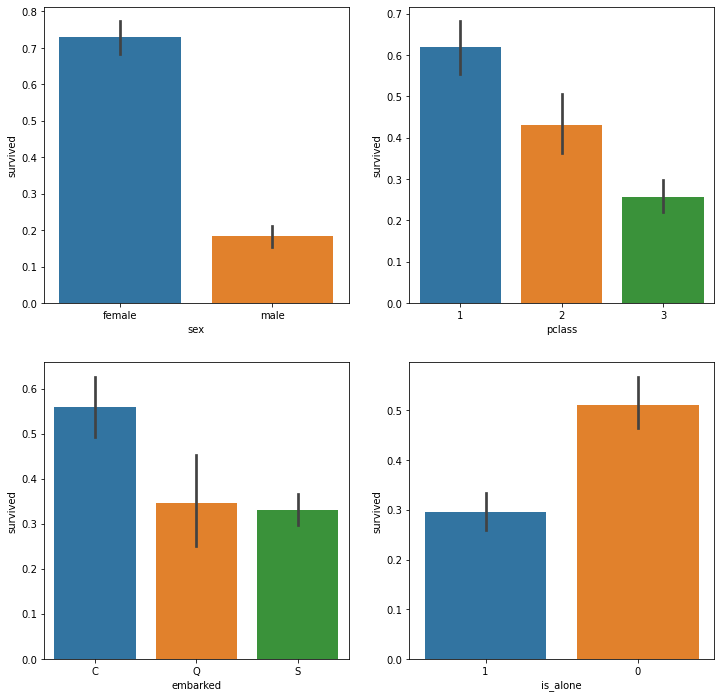

In [31]:
# plot individual categorical features by survival
fig, saxis = plt.subplots(2, 2, figsize=(12,12))

sns.barplot(x = 'sex', y = 'survived', data = titanic_train, ax = saxis[0,0])
sns.barplot(x = 'pclass', y = 'survived', order = [1,2,3], data = titanic_train, ax = saxis[0,1])
sns.barplot(x = 'embarked', y = 'survived', data = titanic_train, ax = saxis[1,0])
sns.barplot(x = 'is_alone', y = 'survived', order = [1,0], data = titanic_train, ax = saxis[1,1])

<AxesSubplot:xlabel='family_size', ylabel='survived'>

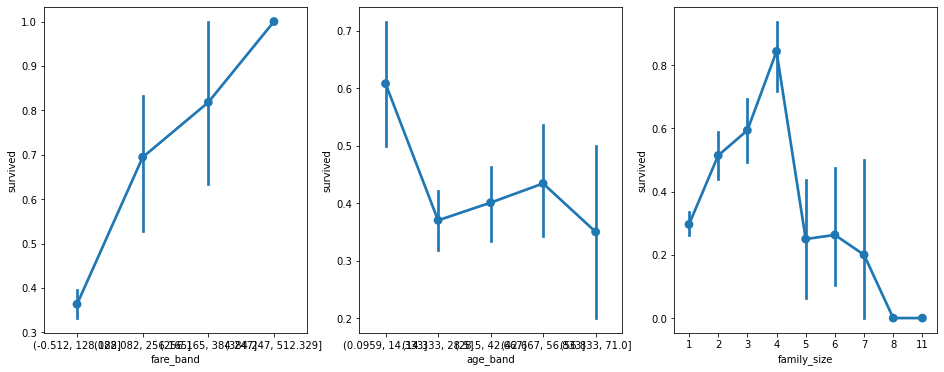

In [32]:
# plot individual continous features by survival
fig, saxis = plt.subplots(1, 3, figsize=(16,6))

sns.pointplot(x = 'fare_band', y = 'survived',  data = titanic_train, ax = saxis[0])
sns.pointplot(x = 'age_band', y = 'survived',  data = titanic_train, ax = saxis[1])
sns.pointplot(x = 'family_size', y = 'survived', data = titanic_train, ax = saxis[2])

ConversionError: Failed to convert value(s) to axis units: 1168    S
1078    Q
957     S
491     C
84      C
       ..
1179    S
95      S
1112    S
282     C
394     S
Name: x, Length: 916, dtype: category
Categories (3, object): ['C', 'Q', 'S']

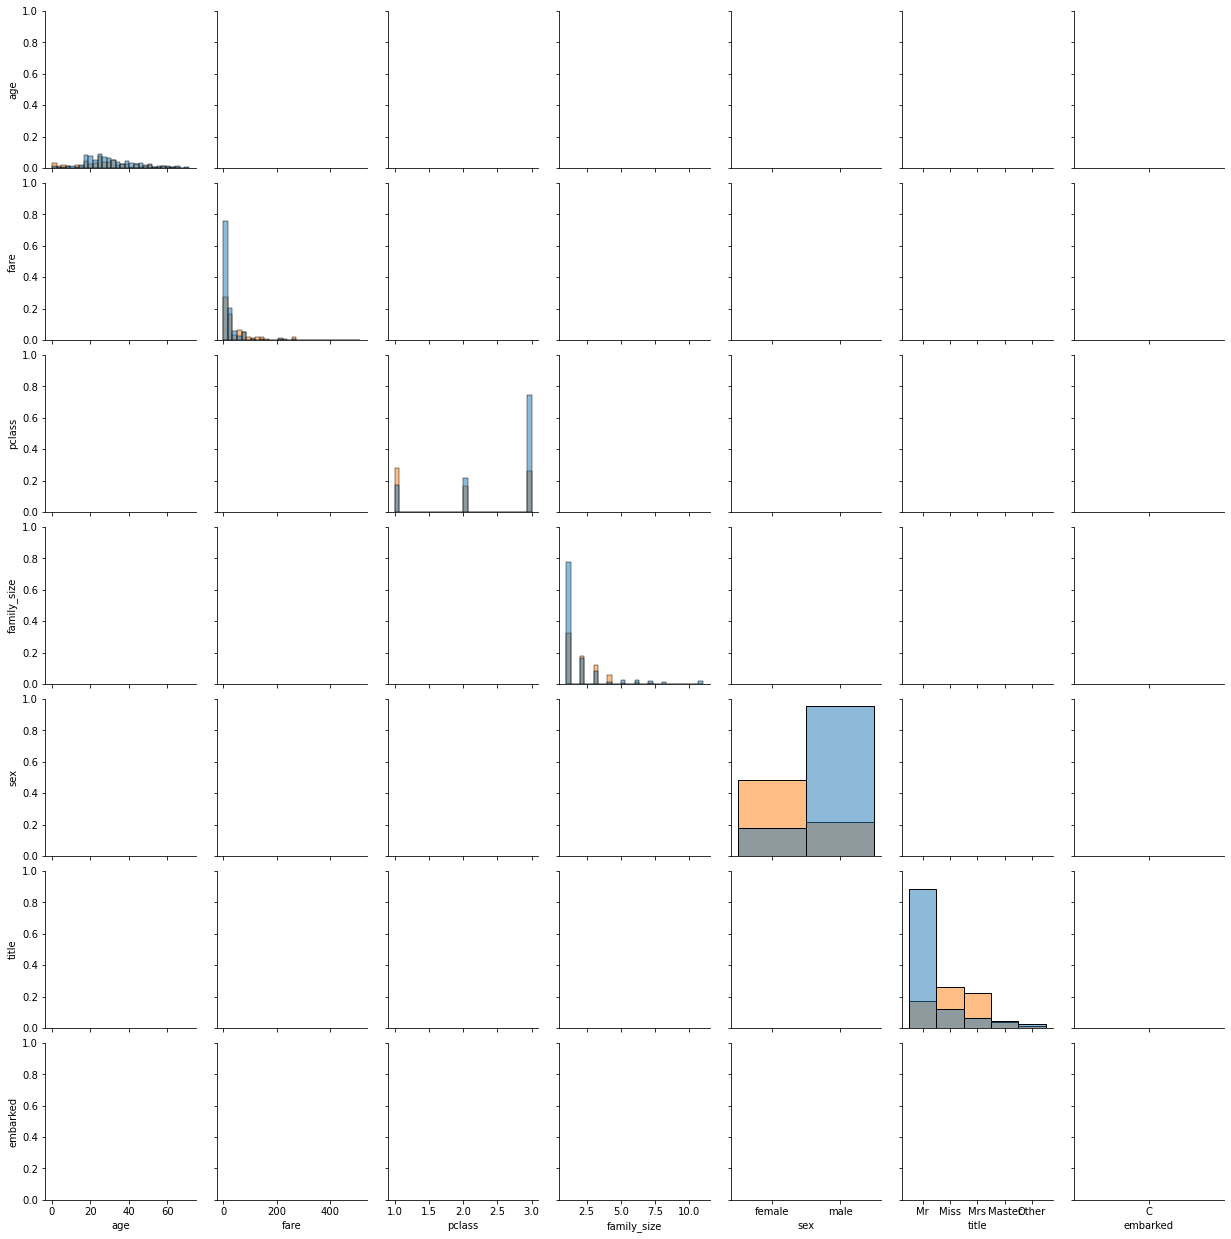

In [33]:
columns = ["age", "fare", "pclass", "family_size", "sex", "title", "embarked"]
g = sns.pairplot(
    data = titanic_train,
    vars = columns,
    hue = "survived",
    #plot_kws = {"alpha": 0.2},
    #height = 3,
    diag_kind = "hist",
    diag_kws = {"bins": 30}
)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

In [ ]:
# Correlation matrix

_ , ax = plt.subplots(figsize =(14, 12))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

titanic_train_cont = titanic_train[["age", "fare", "pclass", "sibsp", "parch", "family_size"]]

_ = sns.heatmap(
    titanic_train_cont.corr(), 
    cmap = colormap,
    square=True, 
    cbar_kws={'shrink':.9 }, 
    ax=ax,
    annot=True, 
    linewidths=0.1,vmax=1.0, linecolor='white',
    annot_kws={'fontsize':12 }
)

plt.title('Pearson Correlation of Features', y=1.05, size=15)

family_size has a high correlation with sibsp and parch as one would expect and so it will be used and the other two variables will be dropped (as a general rule, you will think about dropping columns if the correlation is above 0.7-0.8). 

In [ ]:
# Convert title and pclass to category for what is coming next
titanic_train = titanic_train.astype({"title":"category"})
titanic_test = titanic_test.astype({"title":"category"})

titanic_train = titanic_train.astype({"pclass":"category"})
titanic_test = titanic_test.astype({"pclass":"category"})

### Seperating the features and response variable

In [ ]:
# For the training data
X_train = titanic_train.drop(columns = ['name', 'survived', 'sibsp', 'parch', 'ticket', 'cabin', 'age_band', 'fare_band', 'is_alone'])
y_train = titanic_train['survived']

# For the test data
X_test = titanic_test.drop(columns = ['name', 'survived', 'sibsp', 'parch', 'ticket', 'cabin', 'is_alone'])
y_test = titanic_test['survived']

### Dealing with missing values and feature tranformation

Use ``ColumnTransformer`` by selecting column by names

We will train our classifier with the following features:

Numeric Features:

* ``age``: float;
* ``fare``: float;
* ``family_size``: int.

Categorical Features:

* ``embarked``: categories encoded as strings ``{'C', 'S', 'Q'}``;
* ``sex``: categories encoded as strings ``{'female', 'male'}``;
* ``title``: categories encoded as strings ``{'Master', 'Miss', 'Mr', 'Mrs', 'Other'}``;
* ``pclass``: ordinal integers ``{1, 2, 3}``.

We create the preprocessing pipelines for both numeric and categorical data.
Note that ``pclass`` could either be treated as a categorical or numeric feature.

In [ ]:
num_features = ["age", "fare", "family_size"]
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

cat_features = ["embarked", "sex", "pclass", "title"]
cat_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy = "most_frequent")), ("cat_encoding", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor_linear = ColumnTransformer(
    transformers = [
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ]
)

Append classifier to preprocessing pipeline.
Now we have a full prediction pipeline.



In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor_linear), ("classifier", LogisticRegression(max_iter = 1000))]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

HTML representation of ``Pipeline`` (display diagram)

When the ``Pipeline`` is printed out in a jupyter notebook an HTML
representation of the estimator is displayed:



In [ ]:
clf

Using the prediction pipeline in a grid search

Grid search can also be performed on the different preprocessing steps
defined in the ``ColumnTransformer`` object, together with the classifier's
hyperparameters as part of the ``Pipeline``.
We will search for both the imputer strategy of the numeric preprocessing
and the regularization parameter of the logistic regression using
:class:`~sklearn.model_selection.GridSearchCV`.



In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

Calling 'fit' triggers the cross-validated search for the best
hyper-parameters combination:




In [ ]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

The internal cross-validation scores obtained by those parameters is:



In [ ]:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

We can also introspect the top grid search results as a pandas dataframe:



In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_preprocessor__num__imputer__strategy",
        "param_classifier__C",
    ]
]

The best hyper-parameters have be used to re-fit a final model on the full
training set. We can evaluate that final model on held out test data that was
not used for hyperparameter tuning.




In [ ]:
print(
    (
        "best logistic regression from grid search: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

## Homework

1) Re-run Logistic Regression with the best hyperparameters that were found

2) Perform a more exhaustive grid search, now also including the imputation method for categorical columns (`strategy='most_frequent'` or with `strategy="constant", fill_value="missing"`) and penalty (`'l1'`, `'l2'` or `'elasticnet'`). Select hyperparameters based on F1-score and calculate the common performance metrics (i.e., accuracy, recall, precision, F1-score)

3) Run Decision tree after finding the best hyperparamters with grid search based on F1-score. Include the common performance metrics. Generate and interpret the decision tree. 

4) Run Random forest after finding the best hyperparamters with grid search based on F1-score. Include the common performance metrics. 